In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Lade die CSV mit den Metadaten
metadata = pd.read_csv('company_documents.csv')

# 'Summary'-Spalte wird als liste der Dokumententypen verstanden
metadata['Summary'] = metadata['Summary'].str.split()

# 'Company Name'-Spalte importieren
metadata['Company Name'] = metadata['Company Name'].astype(str)

# Data directory mit den txt files
data_directory = './data/'

# Funktion um den text aus einem file zu lesen
def read_text_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except FileNotFoundError:
        return None

# txt file content zum metadata df hinzufügen
metadata['document_content'] = metadata['TXT Document'].apply(lambda x: read_text_file(os.path.join(data_directory, x)) if pd.notna(x) else None)

# Erste paar Zeilen anzeigen
print(metadata[['Summary', 'Company Name', 'TXT Document', 'document_content']].head())

# Anzahl der geladenen files
print(f"Anzahl der geladenen Dokumente: {len(metadata)}")

# Wenn überhaupt Dokumente geladen wurden, eins anzeigen
if not metadata['document_content'].isna().all():
    print("\nBeispielinhalt eines Dokuments:")
    print(metadata.loc[metadata['document_content'].notna(), 'document_content'].iloc[0][:500])


           Summary Company Name  \
0       [COC, COE]          SAP   
1   [Partner, COC]          SAP   
2  [Supplier, COC]          SAP   
3            [COC]      Siemens   
4  [Supplier, COC]      Siemens   

                                        TXT Document  \
0  SAP_Global_Code_of_Ethics_and_Business_Conduct...   
1                    SAP_Partner_Code_of_Conduct.txt   
2                   SAP_Supplier_Code_of_Conduct.txt   
3          Siemens_business_conduct_guidelines_e.txt   
4       Siemens_Supplier_Code_of_Conduct_English.txt   

                                    document_content  
0  Version 01/2023 | PUBLIC\nGLOBAL CODE OF\nETHI...  
1  PUBLIC\nSAP Partner Code of Conduct\nMay 18, 2...  
2  SAP Supplier Code of Conduct\nVersion 6.0\nDec...  
3  Siemens Business\nConduct Guidelines\nSeptembe...  
4  Siemens Code of Conduct\nfor Suppliers and Thi...  
Anzahl der geladenen Dokumente: 56

Beispielinhalt eines Dokuments:
Version 01/2023 | PUBLIC
GLOBAL CODE OF
ETHICS AND
BUS

In [2]:
from langdetect import detect, DetectorFactory
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, MWETokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import GermanStemmer

# Seed für reproduzierbarkeit
DetectorFactory.seed = 0

# NLTK ressourcen
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def preprocess_text(document, company_name):
    # Firmenname wir din jedem dokument durch 'companyname' ersetzt
    pattern = r'\b({}|{})\b'.format(re.escape(company_name), company_name.replace(' ', r'\s+'))
    document = re.sub(pattern, 'companyname', document, flags=re.IGNORECASE)

    # Sprache versuchen zu erkennen (Bosch ist in deutsch)
    try:
        lang = detect(document)
    except:
        lang = 'unknown'

    # Nicht-Text-Zeichenb entfernen
    document = re.sub(r'[^\w\s]', ' ', document)
    
    # In Kleinbuchstaben verwandeln und tokenisieren
    tokens = word_tokenize(document.lower())

    if lang == 'en':
        # Spezifische behandlung für englisch
        stopwords_list = stopwords.words('english')
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_list and token.isalpha()]
    elif lang == 'de':
        # Spezifische Behandlung für deutsch
        stopwords_list = stopwords.words('german')
        stemmer = GermanStemmer()
        tokens = [stemmer.stem(token) for token in tokens if token not in stopwords_list and token.isalpha()]
    else:
        # Falls irgendwas schief lief: einfaches filtering
        tokens = [token for token in tokens if token.isalpha()]

    return ' '.join(tokens)

# Jedes txt Dokument bearbeiten
metadata['cleaned_document'] = metadata.apply(lambda x: preprocess_text(x['document_content'], x['Company Name']), axis=1)

# Erste paar Zeilen der bearbeiteten Daten anzeigen
print(metadata[['Summary', 'Company Name', 'TXT Document', 'cleaned_document']].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


           Summary Company Name  \
0       [COC, COE]          SAP   
1   [Partner, COC]          SAP   
2  [Supplier, COC]          SAP   
3            [COC]      Siemens   
4  [Supplier, COC]      Siemens   

                                        TXT Document  \
0  SAP_Global_Code_of_Ethics_and_Business_Conduct...   
1                    SAP_Partner_Code_of_Conduct.txt   
2                   SAP_Supplier_Code_of_Conduct.txt   
3          Siemens_business_conduct_guidelines_e.txt   
4       Siemens_Supplier_Code_of_Conduct_English.txt   

                                    cleaned_document  
0  version public global code ethic business cond...  
1  public companyname partner code conduct may de...  
2  companyname supplier code conduct version dece...  
3  companyname business conduct guideline septemb...  
4  companyname code conduct supplier third party ...  


In [3]:
from collections import Counter
import matplotlib.pyplot as plt

# Wörter-frequenz berechen
def get_frequency(data):
    # alle Dokumente in einen großen string zusammenführen
    text = ' '.join(data['cleaned_document'].tolist())
    # Tokenisieren
    tokens = text.split()
    # Frequenz per Token berechnen
    frequency = Counter(tokens)
    return frequency.most_common(30)

common_words = get_frequency(metadata)

print("Most Common Words:")
for word, freq in common_words:
    print(f"{word}: {freq}")

Most Common Words:
companyname: 5877
business: 2891
information: 2076
code: 1757
employee: 1725
policy: 1621
law: 1483
company: 1335
conduct: 1316
may: 1090
compliance: 1049
must: 996
partner: 864
customer: 847
use: 829
work: 787
interest: 780
right: 763
supplier: 737
data: 730
personal: 721
legal: 708
including: 682
report: 679
ethic: 669
product: 652
service: 638
government: 634
security: 626
party: 616


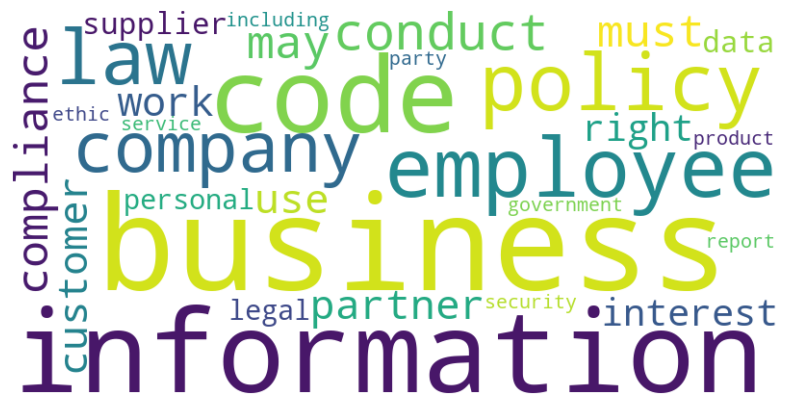

In [4]:
from wordcloud import WordCloud

# Wordcloud generieren
def generate_word_cloud(frequencies):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(frequencies))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Erst-häufigstes wort war immer "companyname", was ich selbst in die dokumente eingefügt hatte
generate_word_cloud(common_words[1::])

In [5]:
from collections import Counter

# Liste der (slebst gesetzten) Kategorien flach machen und Vorkommen zählen
category_counts = Counter([category for sublist in metadata['Summary'] for category in sublist])

# Nummer der Dokumente in jeder Kategorie printen
print("Document counts by category:")
for category, count in category_counts.items():
    print(f"{category}: {count}")

# für die zwei größten Kategorien anzeigen, welche Dokumente dazu gehören
sample_categories = list(category_counts.keys())[:2]
for category in sample_categories:
    print(f"\nDocuments in category {category}:")
    documents_in_category = metadata[metadata['Summary'].apply(lambda x: category in x)]
    for _, row in documents_in_category.iterrows():
        print(f"- {row['TXT Document']}")

Document counts by category:
COC: 43
COE: 21
Partner: 3
Supplier: 2
sustainability_report: 1
Financial: 2
Procurement: 1
Resposibility: 1
AI: 1

Documents in category COC:
- SAP_Global_Code_of_Ethics_and_Business_Conduct_for_Employees.txt
- SAP_Partner_Code_of_Conduct.txt
- SAP_Supplier_Code_of_Conduct.txt
- Siemens_business_conduct_guidelines_e.txt
- Siemens_Supplier_Code_of_Conduct_English.txt
- Siemens_2019_sag_bcg_en.txt
- Infineon_CoC.txt
- telekom_code_of_conduct_en.txt
- Bosch_Code_of_Business_Conduct.txt
- Microsoft_Trust_Code_2022_en_us_2023_0509.txt
- IBM_Business_Conduct_Guidelines.txt
- Google_CoC.txt
- Amazon_CoC.txt
- Intel_code_of_conduct_eng.txt
- Oracle_CoC.txt
- Dell_Technologies_Code_of_Conduct_English.txt
- Tencent_Environmental,_Social_and_Governance_Report.txt
- Huawei_CoC.txt
- SAMSUNG_business_conduct_guidelines_2016.txt
- Nokia_nok2660_code_of_conduct_update_jul2023_eng_v2.txt
- SONY_code_of_conduct_En.txt
- Cisco_fy24_code_of_business_conduct_english.txt
- Ado

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Funktion um topics zu modellieren
def perform_topic_modeling(texts, n_topics=1, n_words=5):
    vectorizer = TfidfVectorizer(stop_words='english')
    dtm = vectorizer.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(dtm)
    topic_words = vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        topics.append(" ".join([topic_words[i] for i in topic.argsort()[:-n_words - 1:-1]]))
    return topics

# Topics für jede Kategorie finden
for category in category_counts.keys():
    documents_text = metadata[metadata['Summary'].apply(lambda x: category in x)]['cleaned_document'].tolist()
    topics = perform_topic_modeling(documents_text, n_topics=1, n_words=5)
    print(f"Topics for category {category}: {topics}")

Topics for category COC: ['companyname business employee information code']
Topics for category COE: ['companyname business employee code company']
Topics for category Partner: ['companyname business partner law shall']
Topics for category Supplier: ['supplier companyname right employee code']
Topics for category sustainability_report: ['companyname compliance group ethic business']
Topics for category Financial: ['financial companyname code concern employee']
Topics for category Procurement: ['companyname business supplier employee procurement']
Topics for category Resposibility: ['companyname company ag group management']
Topics for category AI: ['ai data human solution companyname']


In [7]:
# Topics für jedes Dokument individuell finden
metadata['document_topics'] = metadata['cleaned_document'].apply(lambda x: perform_topic_modeling([x], n_topics=1, n_words=5))

# Generierte Topics ausgeben
for index, row in metadata.iterrows():
    print(f"{row['document_topics']}: Topics for document {row['TXT Document']}")

['companyname business information value global']: Topics for document SAP_Global_Code_of_Ethics_and_Business_Conduct_for_Employees.txt
['companyname partner business information law']: Topics for document SAP_Partner_Code_of_Conduct.txt
['supplier companyname law worker right']: Topics for document SAP_Supplier_Code_of_Conduct.txt
['companyname employee business company law']: Topics for document Siemens_business_conduct_guidelines_e.txt
['right applicable human conduct code']: Topics for document Siemens_Supplier_Code_of_Conduct_English.txt
['companyname business company conduct guideline']: Topics for document Siemens_2019_sag_bcg_en.txt
['companyname business guideline decision conduct']: Topics for document Infineon_CoC.txt
['companyname deutsche employee conduct code']: Topics for document telekom_code_of_conduct_en.txt
['companynam business conduct complianc indd']: Topics for document Bosch_Code_of_Business_Conduct.txt
['trust companyname code page policy']: Topics for document

In [8]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# VADER lexicon für sentiment analyse
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Kategorisieren der sentiment score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Funktion zum Sentiment berechnen
def get_sentiment(text):
    if text:
        sentiment_score = sia.polarity_scores(text)
        return sentiment_score['compound']
    return 0

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
# Texte zusammenführen und sentiment für jede Kategorie berechnen
category_sentiments = {}
for category in category_counts.keys():
    aggregated_text = " ".join(metadata[metadata['Summary'].apply(lambda x: category in x)]['cleaned_document'].dropna())
    sentiment_score = get_sentiment(aggregated_text)
    category_sentiments[category] = categorize_sentiment(sentiment_score)

# Sentiment für jede Kategorie anzeigen
for category, sentiment in category_sentiments.items():
    print(f"Sentiment for category '{category}': {sentiment}")

Sentiment for category 'COC': positive
Sentiment for category 'COE': positive
Sentiment for category 'Partner': positive
Sentiment for category 'Supplier': positive
Sentiment for category 'sustainability_report': positive
Sentiment for category 'Financial': positive
Sentiment for category 'Procurement': positive
Sentiment for category 'Resposibility': positive
Sentiment for category 'AI': positive


In [10]:
# Sentimente berechnen
metadata['sentiment_score'] = metadata['cleaned_document'].apply(get_sentiment)
metadata['sentiment_category'] = metadata['sentiment_score'].apply(categorize_sentiment)

for index, row in metadata.iterrows():
    print(f"Document '{row['TXT Document']}' Sentiment: {row['sentiment_category']} (Score: {row['sentiment_score']})")

Document 'SAP_Global_Code_of_Ethics_and_Business_Conduct_for_Employees.txt' Sentiment: positive (Score: 1.0)
Document 'SAP_Partner_Code_of_Conduct.txt' Sentiment: positive (Score: 0.9998)
Document 'SAP_Supplier_Code_of_Conduct.txt' Sentiment: positive (Score: 0.9999)
Document 'Siemens_business_conduct_guidelines_e.txt' Sentiment: positive (Score: 0.9999)
Document 'Siemens_Supplier_Code_of_Conduct_English.txt' Sentiment: positive (Score: 0.9953)
Document 'Siemens_2019_sag_bcg_en.txt' Sentiment: positive (Score: 1.0)
Document 'Infineon_CoC.txt' Sentiment: positive (Score: 0.9974)
Document 'telekom_code_of_conduct_en.txt' Sentiment: positive (Score: 0.9998)
Document 'Bosch_Code_of_Business_Conduct.txt' Sentiment: positive (Score: 0.9871)
Document 'Microsoft_Trust_Code_2022_en_us_2023_0509.txt' Sentiment: positive (Score: 1.0)
Document 'IBM_Business_Conduct_Guidelines.txt' Sentiment: positive (Score: 1.0)
Document 'Google_CoC.txt' Sentiment: positive (Score: 1.0)
Document 'Amazon_CoC.txt' 

In [11]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import defaultdict

nltk.download('punkt')

# Sätze normalisieren: Punktuation entfernen und in Kleinbuchstaben umwandeln
def normalize_sentence(sentence):
    sentence = re.sub(r'[^\w\s]', '', sentence.lower())
    return sentence

# Wörter sortieren um Sätze in "canonical" Form umzuwandeln
def canonical_form(sentence):
    words = word_tokenize(sentence)
    words.sort()
    return ' '.join(words)

# Sätze extrahieren, normalisieren
def process_document(text, document_id):
    raw_sentences = sent_tokenize(text)
    processed_sentences = []
    for sentence in raw_sentences:
        normalized = normalize_sentence(sentence)
        if len(word_tokenize(normalized)) >= 3:  # Satz sollte min. 3 Wörter haben
            canonical = canonical_form(normalized)
            processed_sentences.append((canonical, document_id))
    return processed_sentences

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
# Dictionary für Sätze und ihre originalen Dokumente
sentence_documents = defaultdict(list)

# Jedes Dokument durchgehen
for index, row in metadata.iterrows():
    if pd.isna(row['document_content']):
        continue
    document_text = row['document_content']
    document_id = row['TXT Document']
    canonical_sentences = process_document(document_text, document_id)
    for canonical, doc_id in canonical_sentences:
        if doc_id not in sentence_documents[canonical]:
            sentence_documents[canonical].append(doc_id)

# Sätze und Dokumente in denen sie vorkommen ausgeben
for sentence, docs in sentence_documents.items():
    if len(docs) > 1:  # Sätze filtern, die in mehr als einem Dokument vorkommen
        print(f"Canonical sentence '{sentence}' appears in documents: {', '.join(docs)}")

Canonical sentence 'all reserved rights' appears in documents: SAP_Global_Code_of_Ethics_and_Business_Conduct_for_Employees.txt, SAP_Partner_Code_of_Conduct.txt, SAP_Supplier_Code_of_Conduct.txt, Oracle_CoC.txt, SONY_code_of_conduct_En.txt, adobe_business_partner_code_of_conduct.txt, NVIDIA_Code_of_Conduct_External.txt, TeamViewerCoC.txt, Capgemini_CBE_2023_English_v3.3.txt, Capgemini_Code_of_Ethics_for_AI_2021_EN.txt
Canonical sentence 'accomplished agree all and applicable be behalf business compliance conducted full in laws of on policies regulations rules sap shall that with you' appears in documents: SAP_Partner_Code_of_Conduct.txt, SAP_Supplier_Code_of_Conduct.txt
Canonical sentence 'activities anything approvals for is of or other perform prohibited proper resources sap sap strictly than to use without work' appears in documents: SAP_Partner_Code_of_Conduct.txt, SAP_Supplier_Code_of_Conduct.txt
Canonical sentence 'be intellectual must of property protected rights sap' appears in

In [13]:
def generate_ngrams(text, n=10):
    tokens = text.split()
    if len(tokens) < n:
        return [text]
    return [' '.join(tokens[i:i + n]) for i in range(len(tokens) - n + 1)]

# Dictionary für Häufigkeiten der n-grams über alle Dokumente verteilt
ngram_frequencies = defaultdict(list)

for index, row in metadata.iterrows():
    if pd.isna(row['cleaned_document']):
        continue
    n_grams = generate_ngrams(row['cleaned_document'])
    for n_gram in n_grams:
        if row['TXT Document'] not in ngram_frequencies[n_gram]:
            ngram_frequencies[n_gram].append(row['TXT Document'])

for n_gram, docs in ngram_frequencies.items():
    if len(docs) > 1:
        print(f"N-gram '{n_gram}' appears in {len(docs)} documents: {', '.join(docs)}")

N-gram 'companyname companyname se companyname affiliate company right reserved see legal' appears in 2 documents: SAP_Global_Code_of_Ethics_and_Business_Conduct_for_Employees.txt, SAP_Partner_Code_of_Conduct.txt
N-gram 'companyname se companyname affiliate company right reserved see legal notice' appears in 2 documents: SAP_Global_Code_of_Ethics_and_Business_Conduct_for_Employees.txt, SAP_Partner_Code_of_Conduct.txt
N-gram 'se companyname affiliate company right reserved see legal notice www' appears in 2 documents: SAP_Global_Code_of_Ethics_and_Business_Conduct_for_Employees.txt, SAP_Partner_Code_of_Conduct.txt
N-gram 'companyname affiliate company right reserved see legal notice www companyname' appears in 2 documents: SAP_Global_Code_of_Ethics_and_Business_Conduct_for_Employees.txt, SAP_Partner_Code_of_Conduct.txt
N-gram 'affiliate company right reserved see legal notice www companyname com' appears in 2 documents: SAP_Global_Code_of_Ethics_and_Business_Conduct_for_Employees.txt, S